## Data Preprocessing 

First let start pre processing the data sets. We will first remove all the punctutations and unnecessary characters from the data. After than we will convert each word into their corresponding index.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import unicodedata
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import files
import pickle


In [ ]:

class Lang:
    def __init__(self,name):
      #Here we are maintaining three dictionaries, one to convert word into index,another index into word and count.
      #Also we are maintaining global count of distinct words.
      self.name=name
      self.word2index={"<start>":1,"<end>":2}
      self.word2count={"<start>":0,"<end>":0}
      self.index2word={1:"<start>",2:"<end>"}
      self.n_count=3
    def addsentence(self,sent):
      s=sent.split(" ")
      for i in s:
        self.addword(i)

    #preprocessing the data. Seperating the words into dictionary
    def addword(self,word):
      if word not in self.word2index:
        self.word2index[word]=self.n_count
        self.word2count[word]=1
        self.index2word[self.n_count]=word
        self.n_count+=1
      else:
        self.word2count[word]+=1
    

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def clean(w):
    # s=unicode_to_ascii(s)
    w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating a space between words and punctation following it
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()
    w = "<start> " + w + " <end>"     # so that the model know when to start and stop predicting
    return w
def read(source,target,links,limit,reverse=False):
  MAX_len=30
  with open(links[source]) as f1,open(links[target]) as f2:
    pairs=[]
    count=0
    for x,y in zip(f1,f2):
      if count>limit:
        break
      x,y=x.strip(),y.strip()
      count+=1
#Because all the other tensors will be padded according to max word length we have to keep an upper cap on max word to limit.
      if len(x)<MAX_len and len(y)<MAX_len:
        pairs.append([clean(x),clean(y)] )
    input_lang=Lang(source)
    output_lang=Lang(target)
    if reverse:
      pairs=[list(reversed(l)) for l in pairs]
      input_lang,output_lang=output_lang,input_lang
    for pair in pairs:
      input_lang.addsentence(pair[0])
      output_lang.addsentence(pair[1])
    print(input_lang.n_count)
    return pairs,input_lang,output_lang

def tokenize(pairs,input_lang,output_lang):
  input_tensor=list([])
  output_tensor=list([])
  print(len(pairs))
  input_tensor=[[input_lang.word2index[word] for word in i[0].split(" ")] for i in pairs]
  output_tensor=[[output_lang.word2index[word] for word in i[1].split(" ")] for i in pairs]
  # input_tensor=tf.keras.preprocessing.sequence.pad_sequences(input_tensor,padding='post')
  # output_tensor=tf.keras.preprocessing.sequence.pad_sequences(output_tensor,padding='post')
  return input_tensor,output_tensor
def pad(tensor):
  tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor
  

In [ ]:
links={}
links["hindi"]="/content/drive/My Drive/IITB_hindi.txt"
links["english"]="/content/drive/My Drive/IITB_english.txt.en"
pairs,input_lang,output_lang=read("hindi","english",links,1000000,reverse=False)

120972


In [ ]:
input_tensor,output_tensor=tokenize(pairs,input_lang,output_lang)

506861


In [ ]:
input_tensor=pad(input_tensor)
output_tensor=pad(output_tensor)
print(input_tensor[0])
print(input_tensor.shape)
print(output_tensor.shape)

[1 3 4 5 6 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(506861, 23)
(506861, 22)


In [ ]:
print(input_tensor[:6])
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index2word[t]))
convert(input_lang,input_tensor[3])

[[ 1  3  4  5  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  7  8  9  4  5 10  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 11 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 13 14  4 15  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 16  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 17  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
1 ----> <start>
13 ----> निजी
14 ----> गुणों
4 ----> को
15 ----> छिपाएं
2 ----> <end>


In [ ]:
#Training test split
input_tensor_train, input_tensor_val, output_tensor_train, output_tensor_val = train_test_split(input_tensor, output_tensor, test_size=0.05)
print(len(input_tensor_train), len(output_tensor_train), len(input_tensor_val), len(output_tensor_val))

481517 481517 25344 25344


In [ ]:
with open('langs.pkl', 'wb') as f:
  pickle.dump(input_lang, f, pickle.HIGHEST_PROTOCOL)
  pickle.dump(output_lang, f, pickle.HIGHEST_PROTOCOL)




All right so far we are done with the pre processing part. Now we will move on to the creating a model.

## The Attention model

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
iterations=int(BUFFER_SIZE/BATCH_SIZE)
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(input_lang.word2index)+1
vocab_tar_size = len(output_lang.word2index)+1

In [ ]:
class Encoder(tf.keras.Model):
  
  def __init__(self,vocab_l,embeding_dim,enc_units,batch_size):
    super(Encoder, self).__init__()
    self.batch_size=batch_size
    self.vocab_l=vocab_l
    self.embeding_dim=embeding_dim
    self.enc_units=enc_units
    self.embedding=tf.keras.layers.Embedding(vocab_l,embedding_dim)
    self.gru=tf.keras.layers.GRU(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

  def call(self,x,hidden):
    x=self.embedding(x)
    output,state=self.gru(x,initial_state=hidden)
    return output,state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size,self.enc_units))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train,output_tensor_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val,output_tensor_val))
val_dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
example_input_batch,example_target_batch=next(iter(dataset))



encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))



<BatchDataset shapes: ((64, 23), (64, 22)), types: (tf.int32, tf.int32)>
Encoder output shape: (batch size, sequence length, units) (64, 23, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [ ]:
with open('tensors1.pkl', 'wb') as f:
  pickle.dump(example_input_batch,f, pickle.HIGHEST_PROTOCOL)
  pickle.dump(example_target_batch,f, pickle.HIGHEST_PROTOCOL)
files.download("tensors1.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 23, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 92916)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([output_lang.word2index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
EPOCHS = 12
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  counter=0

  for (batch, (inp, output)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp,output, enc_hidden)
    total_loss += batch_loss

    if batch % 500 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      checkpoint.save(file_prefix = checkpoint_prefix+"{epoch}".format(epoch=counter))


  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  counter+=1
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2240
Epoch 1 Batch 500 Loss 0.1988
Epoch 1 Batch 1000 Loss 0.2785
Epoch 1 Batch 1500 Loss 0.2630
Epoch 1 Batch 2000 Loss 0.2283
Epoch 1 Batch 2500 Loss 0.2179
Epoch 1 Batch 3000 Loss 0.2122
Epoch 1 Batch 3500 Loss 0.2703
Epoch 1 Batch 4000 Loss 0.2606
Epoch 1 Batch 4500 Loss 0.1912
Epoch 1 Batch 5000 Loss 0.3273
Epoch 1 Batch 5500 Loss 0.2273
Epoch 1 Batch 6000 Loss 0.2450
Epoch 1 Batch 6500 Loss 0.2945
Epoch 1 Batch 7000 Loss 0.2183
Epoch 1 Batch 7500 Loss 0.2428
Epoch 1 Loss 0.2466
Time taken for 1 epoch 5183.7998695373535 sec

Epoch 2 Batch 0 Loss 0.1458
Epoch 2 Batch 500 Loss 0.1502
Epoch 2 Batch 1000 Loss 0.2015
Epoch 2 Batch 1500 Loss 0.1912
Epoch 2 Batch 2000 Loss 0.1591
Epoch 2 Batch 2500 Loss 0.1590
Epoch 2 Batch 3000 Loss 0.1377
Epoch 2 Batch 3500 Loss 0.1929
Epoch 2 Batch 4000 Loss 0.2010
Epoch 2 Batch 4500 Loss 0.1164
Epoch 2 Batch 5000 Loss 0.2259
Epoch 2 Batch 5500 Loss 0.1519
Epoch 2 Batch 6000 Loss 0.1578
Epoch 2 Batch 6500 Loss 0.1889
Epoch 2 Bat

KeyboardInterrupt: ignored

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((30 , 30))
  sentence =clean(sentence)
  inputs=[]
  for i in sentence.split(' '):
    if i in input_lang.word2index:
      inputs.append(input_lang.word2index[i])
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=30,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([output_lang.word2index['<start>']], 0)

  for t in range(30):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += output_lang.index2word[predicted_id] + ' '

    if output_lang.index2word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
print(output_lang.word2index)

{'<start>': 1, '<end>': 2, 'Highlight': 3, 'duration': 4, 'fill': 5, 'color': 6, 'API': 7, 'Browser': 8, 'Hide': 9, 'private': 10, 'attributes': 11, 'Method': 12, 'Property': 13, 'Value': 14, 'IPython': 15, 'Console': 16, 'Event': 17, 'monitor': 18, '_': 19, 'Monitor': 20, 'Events': 21, 'C': 22, 'lear': 23, 'Selection': 24, 'Everything': 25, 'Selected': 26, 'application': 27, 'accessible': 28, 'Source': 29, 'Start': 30, '/': 31, 'stop': 32, 'event': 33, 'recording': 34, 'Clear': 35, 'log': 36, '(no': 37, 'description)': 38, 'Description': 39, 'Show': 40, 'Accessible': 41, 'Perform': 42, 'action': 43, 'Acti': 44, 'on': 45, 'ID': 46, 'Toolkit': 47, 'Version': 48, 'Ap': 49, 'plication': 50, 'Col': 51, 'lection': 52, '0': 53, ',': 54, 'Relative': 55, 'position': 56, 'Size': 57, 'WIDGET': 58, 'Layer': 59, 'MDI': 60, '-': 61, 'Z': 62, 'order': 63, 'Alpha': 64, 'Absolute': 65, 'Co': 66, 'mponent': 67, 'Des': 68, 'ktop': 69, 'Locale:': 70, 'Document': 71, 'Hyperlink': 72, 'H': 73, 'ypertext': 

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))


  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
def translate_acc(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  return result

Input: <start> आपका स्वागत हैं। <end>
Predicted translation: Your your mind . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s

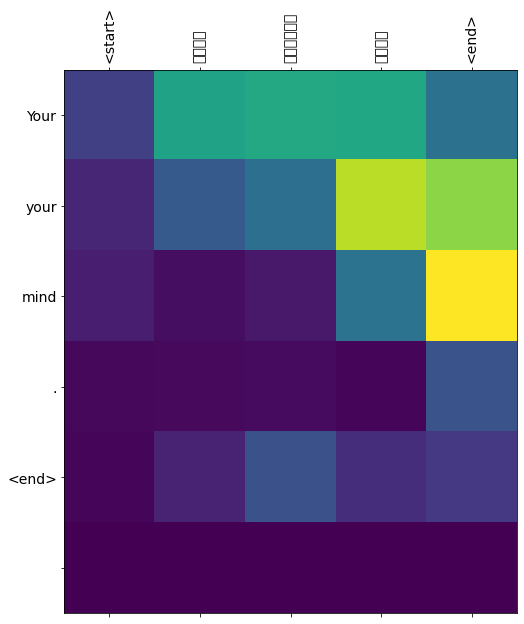

In [ ]:
translate(u"आपका स्वागत हैं।")

In [ ]:
import collections
import math
def evalute_accuracy(input_tensor_val,output_tensor_val):
  target=""
  reference=[]
  candidate=[]
  counter=0
  total=0
  print(output_tensor_val)
  for i in output_tensor_val:
    target+""
    for j in i[1:-1]:
      if j!=1 and j!=0 and j!=2:
        target+=output_lang.index2word[j]+" "
    reference.append(target)
    print(target)

  for i in input_tensor_val:
    predict=""
    for j in i[1:-1]:
      if j!=1 and j!=0 and j!=2:
        predict+=input_lang.index2word[j]+" "
    predict=translate_acc(predict)
    predict.replace("<end>","")
    candidate.append(predict)
    print(reference[counter])
    print(candidate[counter])
    score=compute_bleu(reference[counter],candidate[counter])
    print(score)
    counter+=1
    total+=score[0]
  return total,counter
        
  
  

      
total,counter=evalute_accuracy(input_tensor_val,output_tensor_val)
  # target=""
  # for i in sentence.split()[1:-1]:
  #   

NameError: ignored

In [ ]:
def _get_ngrams(segment, max_order):
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts



def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=True):
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)


